In [1]:
import pandas as pd
import pylab as plt
import seaborn as sns
import numpy as np

%matplotlib inline

datapath="/home/felix/spiced/03_week/data/"

In [2]:
df = pd.read_csv(datapath+'bike_train.csv', parse_dates=True, index_col=0)

#### Split dataset

In [3]:
from sklearn.model_selection import train_test_split
df_train,df_test=train_test_split(df)

df_train.sort_index(inplace=True)
df_test.sort_index(inplace=True)


In [4]:
# define functions for preprocessing

def preprocess(df):
    df["weather"].replace(4,3, inplace=True)
    df["hour"]=[i.hour for i in df.index]
    df["dayname"]=[i.day_name() for i in df.index]
    df["year"]=[i.year for i in df.index]
    df["month"]=[i.month for i in df.index]
    return df


def convert_hour_to_cat(df):
    df["cat_hour"]=pd.cut(df["hour"], [0,6,10,15,20,24],include_lowest=True, labels=["night","morning","noon","afternoon","night2"])
    df.loc[df["cat_hour"]=="night2","cat_hour"]="night"
    return df

def drops(df):
    df=df.drop(["holiday", "hour", "registered", "casual"], axis=1)
    return df


In [5]:
# Define Function Transformer

from sklearn.preprocessing import FunctionTransformer

expand_features=FunctionTransformer(preprocess, feature_names_out="one-to-one")
add_cat_hour=FunctionTransformer(convert_hour_to_cat, feature_names_out="one-to-one")
dropsFT=FunctionTransformer(drops, feature_names_out="one-to-one")


In [6]:
# create column Transformer Pipeline

from sklearn.pipeline import Pipeline

preprocessing_steps = [('expander',expand_features), 
                       ('adcath', add_cat_hour),
                       ('drop', dropsFT)]

Preprocessing_transformer=Pipeline(preprocessing_steps)

dfft=Preprocessing_transformer.fit_transform(df_train)


In [7]:
cat_features   = ['season', 'workingday', 'dayname', 'cat_hour', 'weather']
num_features   = ['temp', 'atemp', 'humidity', 'windspeed',  'year', 'month' ]
scale_features = ['temp', 'atemp', 'humidity', 'windspeed']

In [8]:
from sklearn.preprocessing import OneHotEncoder

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


categorical_steps = [('onehot', OneHotEncoder(handle_unknown='ignore'))]
categorical_transformer = Pipeline(categorical_steps)

numeric_steps = [('scaler', StandardScaler())]
numeric_transformer  = Pipeline(numeric_steps)

In [10]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
        ('numeric', numeric_transformer, scale_features),
        ('categorical', categorical_transformer, cat_features)])


In [11]:
preprocessor.fit_transform(df_train).shape

(8164, 24)

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

final_steps = [('custom_preprocessing', Preprocessing_transformer),
     ('preprocessor', preprocessor),
     #('LinReg', LinearRegression())] # instanciation of the model class
     ('RanFor', RandomForestClassifier())] # instanciation of the model class
pipeline = Pipeline(final_steps)

####  CROSS VALIDATION to optimize Hyperparameters of Random Forrest Classifier

In [13]:
hyperparam_grid = {
    'RanFor__n_estimators': [5, 10, 100, 200],
    'RanFor__min_samples_leaf': [5, 10, 20],}


In [14]:
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(estimator=pipeline, 
                  param_grid=hyperparam_grid,                    
                  cv=5,                                         
                  scoring='accuracy')

In [15]:
Xtrain=df_train.drop("count", axis=1)
Ytrain=df_train["count"]
grid_search = gs.fit(Xtrain, Ytrain)

/home/felix/miniconda3/envs/NewSpiced/lib/python3.10/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [16]:
pd.DataFrame(grid_search.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_RanFor__min_samples_leaf,param_RanFor__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.221649,0.134247,0.148547,0.082911,20,10,"{'RanFor__min_samples_leaf': 20, 'RanFor__n_es...",0.015922,0.015309,0.007348,0.011023,0.014706,0.012862,0.003241,1
5,0.182329,0.019696,0.089526,0.000780,10,10,"{'RanFor__min_samples_leaf': 10, 'RanFor__n_es...",0.012860,0.013472,0.011023,0.012860,0.011642,0.012371,0.000899,2
8,0.145012,0.059579,0.073706,0.034835,20,5,"{'RanFor__min_samples_leaf': 20, 'RanFor__n_es...",0.011635,0.008573,0.009186,0.009798,0.018995,0.011637,0.003819,3
11,1.541821,0.044312,1.477123,0.236030,20,200,"{'RanFor__min_samples_leaf': 20, 'RanFor__n_es...",0.014697,0.011023,0.008573,0.009186,0.014706,0.011637,0.002629,4
10,0.982230,0.200763,0.892388,0.124198,20,100,"{'RanFor__min_samples_leaf': 20, 'RanFor__n_es...",0.013472,0.012247,0.006736,0.007348,0.013480,0.010657,0.002992,5
6,1.111672,0.070315,0.781536,0.175041,10,100,"{'RanFor__min_samples_leaf': 10, 'RanFor__n_es...",0.014697,0.011023,0.007348,0.007348,0.012868,0.010657,0.002941,6
7,2.289979,0.080306,1.545130,0.157660,10,200,"{'RanFor__min_samples_leaf': 10, 'RanFor__n_es...",0.014085,0.011023,0.005511,0.006736,0.015319,0.010535,0.003883,7
0,0.226653,0.033011,0.095248,0.009897,5,5,"{'RanFor__min_samples_leaf': 5, 'RanFor__n_est...",0.014697,0.008573,0.007961,0.010410,0.008578,0.010044,0.002467,8
4,0.129130,0.023986,0.057016,0.000376,10,5,"{'RanFor__min_samples_leaf': 10, 'RanFor__n_es...",0.011023,0.014697,0.006124,0.006736,0.011029,0.009922,0.003156,9
3,4.202122,0.513316,1.552486,0.124710,5,200,"{'RanFor__min_samples_leaf': 5, 'RanFor__n_est...",0.011023,0.008573,0.009186,0.009186,0.009804,0.009554,0.000831,10


best values found:

min_samples_leaf:20  und  n_estimators:10

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

final_steps = [('custom_preprocessing', Preprocessing_transformer),
     ('preprocessor', preprocessor),
     #('LinReg', LinearRegression())] # instanciation of the model class
     ('RanFor', RandomForestClassifier(n_estimators=10, min_samples_leaf=20))] # instanciation of the model class
pipeline = Pipeline(final_steps)

In [50]:
from friendly.jupyter import *
Xtrain=df_train.drop("count", axis=1)
Ytrain=df_train["count"]
pipeline.fit(Xtrain,Ytrain)
print(pipeline.score(Xtrain,Ytrain))

Xtest=df_test.drop("count", axis=1)
Ytest=df_test["count"]

print(pipeline.score(Xtest,Ytest))


from sklearn.metrics import mean_squared_log_error
Y_testpred = pipeline.predict(Xtest)
Y_testpred[Y_testpred<0]=0
Y_testpred=Y_testpred.round().astype(int)

Y_trainpred = pipeline.predict(Xtrain)
Y_trainpred[Y_trainpred<0]=0
Y_trainpred=Y_trainpred.round().astype(int)



#kaggle_score = np.sqrt(mean_squared_log_error(y_true=Ytest, y_pred=Y_testpred))
#print(kaggle_score)


#from sklearn.metrics import  classification_report,accuracy_score

#print(accuracy_score(Ytest, Y_testpred))

0.21055854973052426
0.018736223365172666


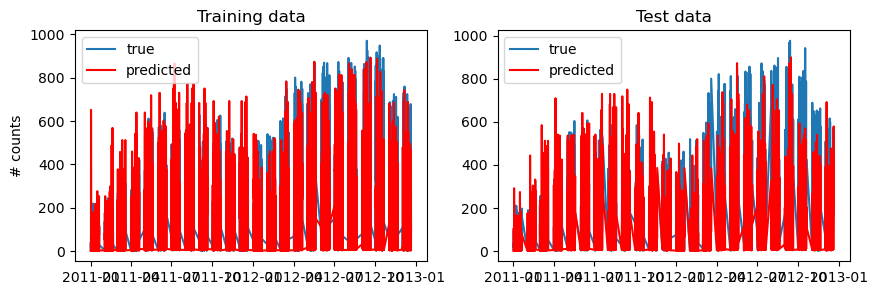

In [51]:

fig=plt.figure(figsize=(10,3))
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

ax1.plot(Ytrain, label="true")
ax1.plot(Ytrain.index,Y_trainpred, "r-", label="predicted")
ax2.plot(Ytest, label="true")
ax2.plot(Ytest.index,Y_testpred, "r-", label="predicted")

ax1.set_ylabel("# counts")

ax1.legend()
ax2.legend()

ax1.set_title("Training data")
ax2.set_title("Test data")

